In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import json

sns.set(font_scale=1.8, style="ticks")

In [2]:
year2result = defaultdict(dict)
month="02"
for subtype in ("h1n1", "h3n2"):
    for year in range(2012, 2022):
        if year in (2020, 2021):
            continue
        vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)

        if not os.path.exists(vaccine_scores_path):
            continue
        
        for file in os.listdir(vaccine_scores_path):
            if file == "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
                if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                    our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                    year2result[subtype][year] = our_model
    


In [3]:
list(year2result["h3n2"].keys())

[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [21]:
year2subtype_counting = json.load(open("../../data/flu_hospitalizations/subtype_count_per_year_us.json"))
year2subtype_counting = {int(year): counts for year, counts in year2subtype_counting.items()}

In [22]:
ref_vaccine_scores = []
ref_vaccine_scores_gt = []
ref_source = []
ref_subtype = []
ref_ve = []
ref_years = []

for subtype in year2result:
    for year in year2result[subtype]:    
        ref_vaccine_score_pred = []
        ref_vaccine_score_gt = []
        for gt_score_clade, score, name, coverage in zip(year2result[subtype][year]["gt_score_seq"], year2result[subtype][year]["score"], year2result[subtype][year]["strain_name"], year2result[subtype][year]["coverage_seq"]):
            if coverage < 0.4:
                continue
            ref_vaccine_score_pred.append(score)
            ref_vaccine_score_gt.append(gt_score_clade)

        if len(ref_vaccine_score_pred) > 0:
            ref_vaccine_score = [x  for x in ref_vaccine_score_pred if not np.isnan(x)]
            if len(ref_vaccine_score) > 0:
                ref_vaccine_scores.append(np.median(ref_vaccine_score))
                ref_source.append("Prediction")
                ref_subtype.append(subtype)
                ref_years.append(year)

            ref_vaccine_score_gt = [x  for x in ref_vaccine_score_gt if not np.isnan(x)]
            if len(ref_vaccine_score_gt) > 0:
                ref_vaccine_scores.append(np.median(ref_vaccine_score_gt))
                ref_source.append("Ground-truth")
                ref_subtype.append(subtype)
                ref_years.append(year)



In [23]:
ref_vaccine_scores = np.asarray(ref_vaccine_scores)
d = {'escapability score': - ref_vaccine_scores, 'subtype': ref_subtype, '': ref_source, "year": ref_years}
res = pd.DataFrame(data=d)

In [24]:
method_year2score = dict()
for method in ("Prediction", "Ground-truth"):
    year2score = defaultdict(float)
    _res = res[res[""] == method]
    for year, subtype, score in zip(_res["year"], _res["subtype"], _res["escapability score"]):
        subtype_count = year2subtype_counting[year][subtype]
        year2score[year]+=((subtype_count * score) / (year2subtype_counting[year]["h1n1"] + year2subtype_counting[year]["h3n2"]))
    method_year2score[method] = year2score

In [25]:
averted_df = pd.read_csv("../../data/flu_hospitalizations/averted_burden.csv")
averted_df["year"] = np.asarray([int(x.split("-")[0]) for x in averted_df["Season"]], np.int64)
for metric in ("Averted Symptomatic Illnesses", "Averted Medical Visits"):
    averted_df[metric] = np.asarray([x.replace(",", "") for x in averted_df[metric]], dtype=np.float32) 
for method in ("Prediction", "Ground-truth"):
    averted_df[method] = [method_year2score[method].get(year, np.nan) for year in averted_df["year"]]

In [26]:
total_burden = pd.read_csv("../../data/flu_hospitalizations/flu-disease-burden-past-season-rounded-estimates-all-ages.csv")
total_burden["year"] = np.asarray([int(x.split("-")[0]) for x in total_burden["Flu Season"]], np.int64)
assert (total_burden["year"] == averted_df["year"]).all()
averted_df["Averted Symptomatic Illnesses Ratio"] = averted_df["Averted Symptomatic Illnesses"] / total_burden["Symptomatic Illnesses"]
averted_df["Averted Medical Visits Ratio"] = averted_df["Averted Medical Visits"] / total_burden["Medical Visits"]

/tmp/ipykernel_2991840/3613667369.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _averted_df = _averted_df[~np.isnan(averted_df["Ground-truth"])]


R=0.72036242354798, P=0.04384314707286937


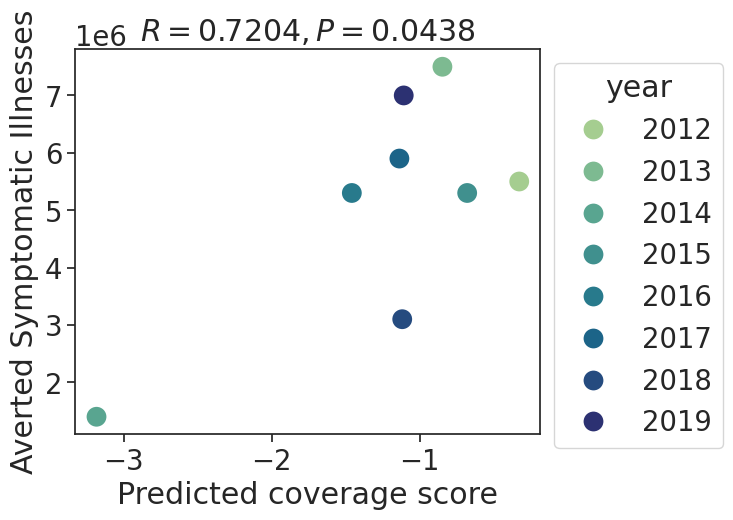

R=0.7366387135167313, P=0.03712135384309068


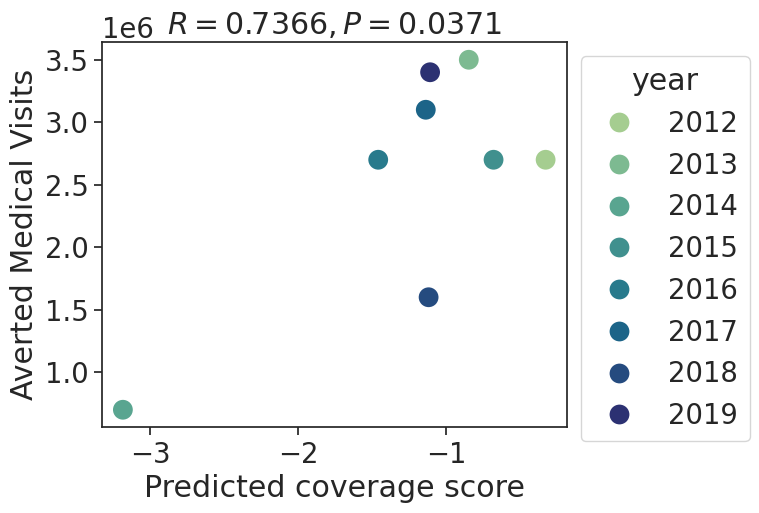

R=0.7218979122035705, P=0.04317989471355085


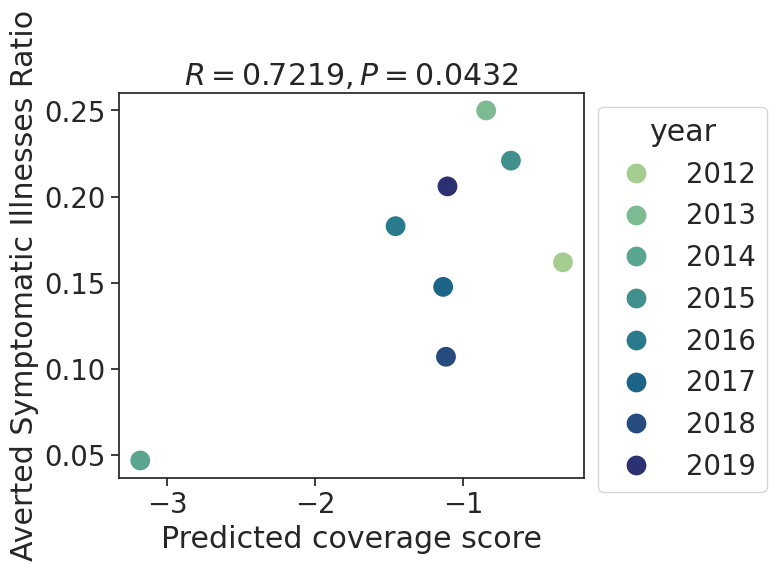

R=0.7291773867062662, P=0.04011845548900804


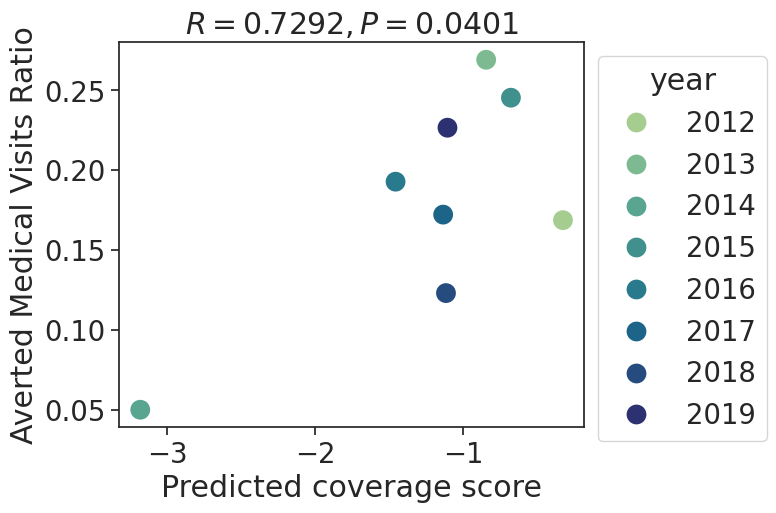

In [27]:
_averted_df = averted_df[~np.isnan(averted_df["Prediction"]) ]
_averted_df = _averted_df[~np.isnan(averted_df["Ground-truth"])]

_averted_df["Year"] = ["_%s" % x if x not in ('2013', '2021') else x for x in _averted_df["year"]]

model = "Prediction"

for i, metric in enumerate(("Averted Symptomatic Illnesses", "Averted Medical Visits", "Averted Symptomatic Illnesses Ratio", "Averted Medical Visits Ratio")): # , "Averted_ratio", "Averted_ratio_their"
    plt.figure(figsize=(6, 5))
    ax = sns.scatterplot(_averted_df, y=metric, x=model, hue="year", s=240, palette="crest", legend="full") #     
    ax.set_ylabel(metric)
    ax.set_xlabel("Predicted coverage score")
    r, r_p = stats.pearsonr(_averted_df[metric][~np.isnan(_averted_df[metric])], _averted_df[model][~np.isnan(_averted_df[metric])])
    print(f"R={r}, P={r_p}")
    ax.set_title(f"$R=%.4lf,P=%.4lf$" % (r, r_p))
    if i < 0:
        plt.legend([],[], frameon=False)
    else:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
    plt.savefig("figs/%s_with_score_prediction.pdf" % (metric.lower().replace(" ", "_")), format='pdf', bbox_inches='tight')
    plt.show()

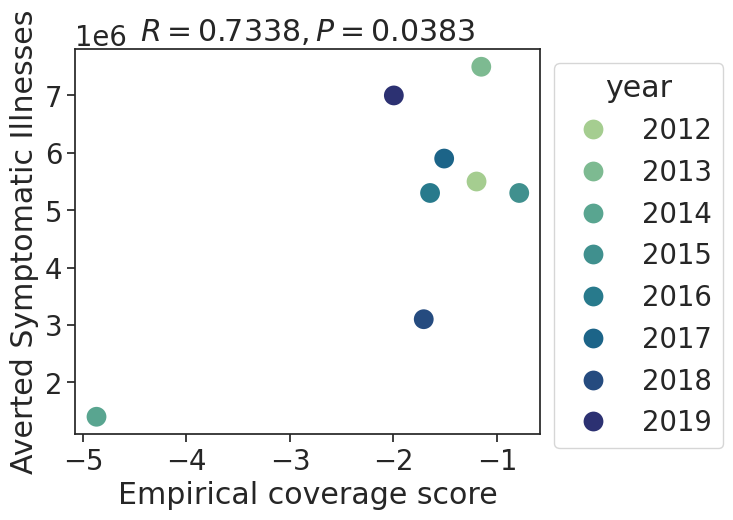

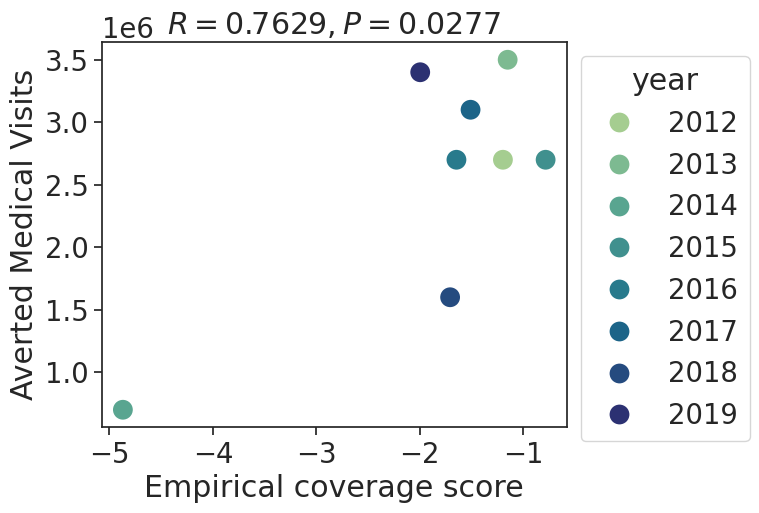

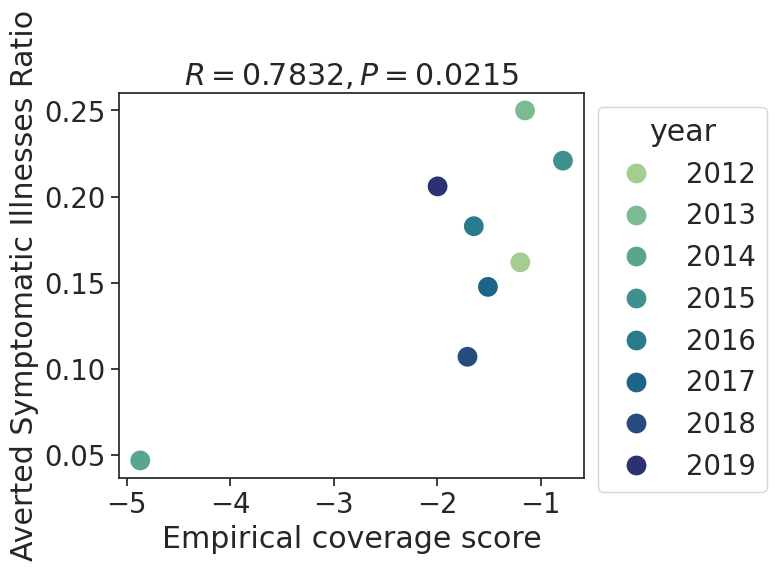

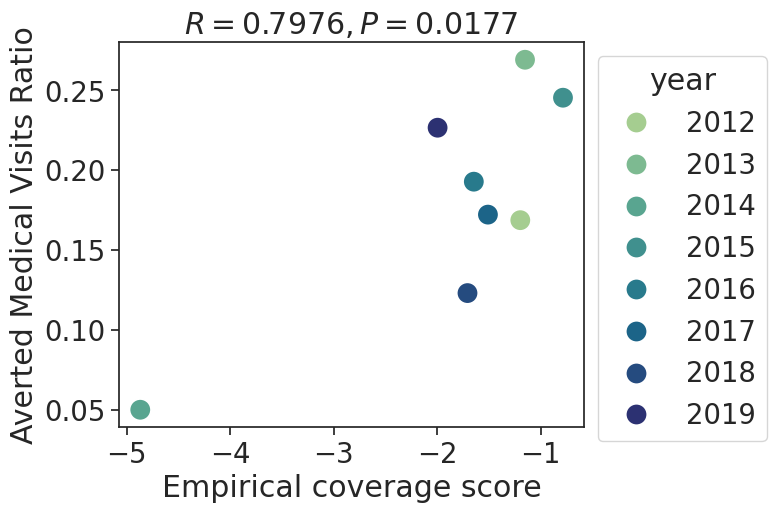

In [19]:
model = "Ground-truth"

for metric in ("Averted Symptomatic Illnesses", "Averted Medical Visits", "Averted Symptomatic Illnesses Ratio", "Averted Medical Visits Ratio"):
    plt.figure(figsize=(6, 5))
    ax = sns.scatterplot(_averted_df, y=metric, x=model, hue="year", legend="full", s=240, palette="crest")
    ax.set_ylabel(metric)
    ax.set_xlabel("Empirical coverage score")
    r, r_p = stats.pearsonr(_averted_df[metric][~np.isnan(_averted_df[metric])], _averted_df[model][~np.isnan(_averted_df[metric])])
    ax.set_title(f"$R=%.4lf,P=%.4lf$" % (r, r_p))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig("figs/%s_with_score_gt.pdf" % (metric.lower().replace(" ", "_")), format='pdf', bbox_inches='tight')
    plt.show()

In [ ]:
ve = pd.read_csv("/data/rbg/users/wxsh/vaxseer/data/vaccine_effectiveness/overall_ve.csv")
ve # ["Influenza Season†"]
ve["Year"] = [x.split("-")[0] for x in ve["Influenza Season†"]]
season2ve = dict(zip(ve["Year"], ve["Adjusted Overall VE (%)"]))

In [ ]:
season2ve

In [ ]:
_averted_df["VE"] = [season2ve[season.split("-")[0]] for season in _averted_df["Season"]]

In [ ]:
model = "VE"

for metric in ("Averted Symptomatic Illnesses", "Averted Medical Visits"):
    ax = sns.scatterplot(_averted_df, y=metric, x=model, hue="year", legend="full", s=240, palette="crest")
    ax.set_ylabel(metric)
    ax.set_xlabel("Vaccine effectiveness")
    
    r, r_p = stats.pearsonr(_averted_df[metric], _averted_df[model])
    print(r, r_p)
    
    ax.set_title(f"$R=%.4lf,P=%.4lf$" % (r, r_p))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig("figs/%s_with_ve.pdf" % (metric.lower().replace(" ", "_")), format='pdf', bbox_inches='tight')
    plt.show()